In [3]:
import numpy as np
import SimpleITK as sitk
import matplotlib.pyplot as plt


In [ ]:
def extract_masks(masks_path, mask_labels):

    """
    This function is used to extract new masks with the given labels from raw masks .

    Parameters
    ----------
    masks_path : list
        The list of the paths of raw masks
    mask_labels : list
        The list of targrt labels in the raw masks

    Returns
    -----------

    """

    for path in masks_path:

        mask_image = sitk.ReadImage(path,sitk.sitkFloat32)
        mask_data = sitk.GetArrayFromImage(mask_image)

        new_mask_data = np.zeros_like(mask_data)
        
        info = ".nii.gz"
        for i in mask_labels:
            new_mask_data[np.where(mask_data==i)]=i
            info = "_" + str(i) + info
        
        new_mask_image = sitk.GetImageFromArray(new_mask_data)
        writer = sitk.ImageFileWriter()
        writer.SetImageIO("NiftiImageIO")
        path = path.replace(".nii.gz",info)
        writer.SetFileName(path)
        writer.Execute(new_mask_image)
        print("The new mask is saved as '{}'.".format(path))

In [108]:
img = sitk.ReadImage('/Users/xinyi/Documents/GitHub/Segmentationof-pelvic-bone-in-CT/data/common_40_image.nii.gz', sitk.sitkFloat32)
img_data = sitk.GetArrayFromImage(img)

In [119]:
mask = sitk.ReadImage('/Users/xinyi/Downloads/seg.nii.gz', sitk.sitkFloat32)
mask_data = sitk.GetArrayFromImage(mask)

In [120]:
np.unique(mask_data)

array([0.], dtype=float32)

In [97]:
mask_z = sitk.ReadImage('/Users/xinyi/Downloads/common_40_mask_2c (1).nii.gz', sitk.sitkFloat32)
mask_z_data = sitk.GetArrayFromImage(mask_z)

mask_4_2 = sitk.ReadImage('/Users/xinyi/Documents/GitHub/Segmentationof-pelvic-bone-in-CT/data/common_40_mask_4_2.nii.gz', sitk.sitkFloat32)
mask_4_2_data = sitk.GetArrayFromImage(mask_4_2)

In [98]:
labels = np.unique(mask_data)[1:]
labels

array([1., 2., 3., 4., 5.], dtype=float32)

In [95]:
labels[1]

2.0

In [ ]:
new_mask_data = np.zeros_like(mask_data)
new_mask_data[np.where(mask_data==)]=i

new_mask_image = sitk.GetImageFromArray(new_mask_data)

Text(0.5, 1.0, 'Reference image and moving image')

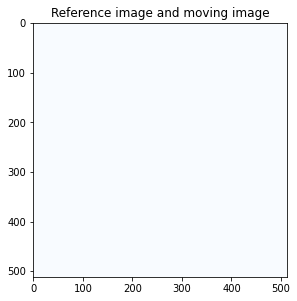

In [105]:
idx = 100
plt.figure(figsize=(10,20))
plt.subplot(121)
# plt.imshow(img_data[idx], cmap='Greens') # fixed image
plt.imshow(mask_data[idx], cmap='Blues', alpha= 0.8) # fixed image
# plt.imshow(mask_4_2_data[idx], cmap = 'Reds', alpha = 0.3)
plt.title('Reference image and moving image')

In [41]:
from utils.callbacks import start_plot, end_plot, update_multires_iterations, plot_values


In [76]:
def est_lin_transf_t(fix_img, fix_mask, mov_img):

    """
    This function is used to estimated the linear transformation from mov_img to fix_img.

    Parameters
    ----------
    fix_img : Image
        The reference image
    mov_img : Image
        The moving image
    fix_mask : Image
        The mask of reference image

    Returns
    -----------
    final_transform : Transform (SITK.Transform)
        The esmated transformation

    """

    # initialize alignment of two volumes
    initial_transform = sitk.CenteredTransformInitializer(fix_img, mov_img, sitk.AffineTransform(3), sitk.CenteredTransformInitializerFilter.GEOMETRY)

    # initialize the registration
    registration_method = sitk.ImageRegistrationMethod()

    # Metric settings
    registration_method.SetMetricAsMeanSquares()
    # registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=50)
    registration_method.SetMetricSamplingStrategy(registration_method.RANDOM)
    registration_method.SetMetricSamplingPercentage(0.001)

    # set the mask on which you are going to evaluate the similarity between the two images
    registration_method.SetMetricFixedMask(fix_mask)

    # Set interpolator
    registration_method.SetInterpolator(sitk.sitkLinear)

    # Set gradient descent optimizer
    registration_method.SetOptimizerAsGradientDescent(learningRate=1, 
                                                      numberOfIterations=100, 
                                                      convergenceMinimumValue=1e-6,
                                                      convergenceWindowSize=10)

    registration_method.SetOptimizerScalesFromPhysicalShift()

    # Setup for the multi-resolution framework
    registration_method.SetShrinkFactorsPerLevel(shrinkFactors=[4, 2, 1])
    registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[2, 1, 0])
    registration_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()

    # Set the initial transformation 
    registration_method.SetInitialTransform(initial_transform, inPlace=False)

    # Connect all of the observers so that we can perform plotting during registration.
    registration_method.AddCommand(sitk.sitkStartEvent, start_plot)
    registration_method.AddCommand(sitk.sitkEndEvent, end_plot)
    registration_method.AddCommand(sitk.sitkMultiResolutionIterationEvent, update_multires_iterations) 
    registration_method.AddCommand(sitk.sitkIterationEvent, lambda: plot_values(registration_method))
    

    # perform registration
    final_transform = registration_method.Execute(sitk.Cast(fix_img, sitk.sitkFloat32),
                                                  sitk.Cast(mov_img, sitk.sitkFloat32))

    print("--------")
    print("Linear registration:")
    print('Final mean squares value: {0}'.format(registration_method.GetMetricValue()))
    print("Optimizer stop condition: {0}".format(registration_method.GetOptimizerStopConditionDescription()))
    print("Number of iterations: {0}".format(registration_method.GetOptimizerIteration()))
    print("--------")
    return final_transform

In [85]:
len(mask.GetMetaDataKeys())

56

In [87]:
mask.GetMetaDataKeys()

('ITK_FileNotes',
 'ITK_original_direction',
 'ITK_original_spacing',
 'aux_file',
 'bitpix',
 'cal_max',
 'cal_min',
 'datatype',
 'descrip',
 'dim[0]',
 'dim[1]',
 'dim[2]',
 'dim[3]',
 'dim[4]',
 'dim[5]',
 'dim[6]',
 'dim[7]',
 'dim_info',
 'intent_code',
 'intent_name',
 'intent_p1',
 'intent_p2',
 'intent_p3',
 'nifti_type',
 'pixdim[0]',
 'pixdim[1]',
 'pixdim[2]',
 'pixdim[3]',
 'pixdim[4]',
 'pixdim[5]',
 'pixdim[6]',
 'pixdim[7]',
 'qfac',
 'qform_code',
 'qform_code_name',
 'qoffset_x',
 'qoffset_y',
 'qoffset_z',
 'qto_xyz',
 'quatern_b',
 'quatern_c',
 'quatern_d',
 'scl_inter',
 'scl_slope',
 'sform_code',
 'sform_code_name',
 'slice_code',
 'slice_duration',
 'slice_end',
 'slice_start',
 'srow_x',
 'srow_y',
 'srow_z',
 'toffset',
 'vox_offset',
 'xyzt_units')

In [ ]:
print(mask.GetMetaData(i))
print(mask_4_2.GetMetaData(i))

In [106]:
for i in mask.GetMetaDataKeys():
    print(i)
    print(mask.GetMetaData(i))
    print(mask_z.GetMetaData(i))
    print(mask_4_2.GetMetaData(i))

ITK_FileNotes



ITK_original_direction
[UNKNOWN_PRINT_CHARACTERISTICS]

[UNKNOWN_PRINT_CHARACTERISTICS]

[UNKNOWN_PRINT_CHARACTERISTICS]

ITK_original_spacing
[UNKNOWN_PRINT_CHARACTERISTICS]

[UNKNOWN_PRINT_CHARACTERISTICS]

[UNKNOWN_PRINT_CHARACTERISTICS]

aux_file



bitpix
32
16
32
cal_max
0
0
0
cal_min
0
0
0
datatype
16
512
16
descrip



dim[0]
3
3
3
dim[1]
512
512
512
dim[2]
512
512
512
dim[3]
286
286
286
dim[4]
1
1
1
dim[5]
1
1
1
dim[6]
1
1
1
dim[7]
1
1
1
dim_info
0
0
0
intent_code
0
0
0
intent_name



intent_p1
0
0
0
intent_p2
0
0
0
intent_p3
0
0
0
nifti_type
1
1
1
pixdim[0]
0
0
0
pixdim[1]
0.664062
0.664062
1
pixdim[2]
0.664062
0.664062
1
pixdim[3]
0.799988
0.799988
1
pixdim[4]
0
0
0
pixdim[5]
0
0
0
pixdim[6]
0
0
0
pixdim[7]
0
0
0
qfac
[UNKNOWN_PRINT_CHARACTERISTICS]

[UNKNOWN_PRINT_CHARACTERISTICS]

[UNKNOWN_PRINT_CHARACTERISTICS]

qform_code
1
1
1
qform_code_name
NIFTI_XFORM_SCANNER_ANAT
NIFTI_XFORM_SCANNER_ANAT
NIFTI_XFORM_SCANNER_ANAT
qoffset_x
168.668
168.668
-0
qoffset_y

In [48]:
np.unique(mask_4_2_data)

array([0, 2, 4], dtype=uint8)

In [53]:
np.unique(mask_data)

array([0, 1, 3], dtype=uint8)

In [50]:
fix_img = sitk.ReadImage('./data/common_40_image.nii.gz', sitk.sitkFloat32)
fix_img_data = sitk.GetArrayFromImage(fix_img)
mov_img = sitk.ReadImage('/Users/xinyi/Documents/GitHub/Segmentationof-pelvic-bone-in-CT/data/g1_53_image.nii.gz',sitk.sitkFloat32)
mov_img_data = sitk.GetArrayFromImage(mov_img)

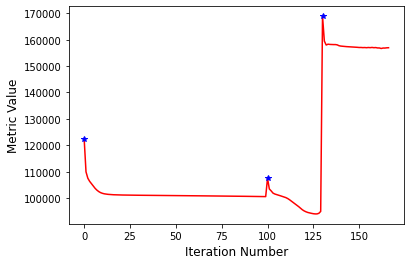

--------
Linear registration:
Final mean squares value: 157092.73560087255
Optimizer stop condition: GradientDescentOptimizerv4Template: Convergence checker passed at iteration 37.
Number of iterations: 37
--------


In [77]:
from utils.registration import est_lin_transf
lin_tranf = est_lin_transf_t(fix_img, mask, mov_img)  

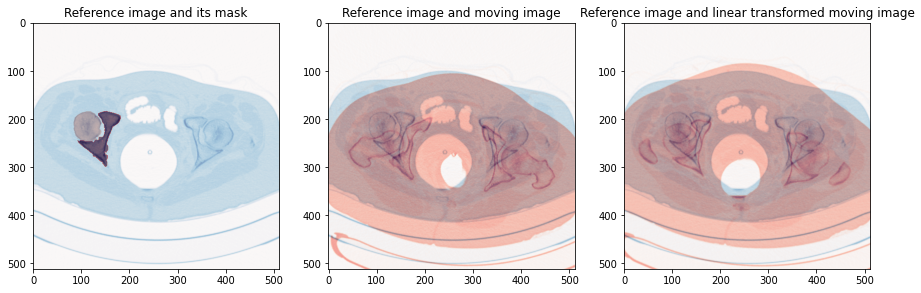

In [78]:
from utils.plot_methods import plot_lin_transf
from utils.registration import apply_lin_transf
re_mov_img = apply_lin_transf(fix_img, mov_img, lin_tranf)
plot_lin_transf(fix_img, mask, mov_img, re_mov_img, 80)

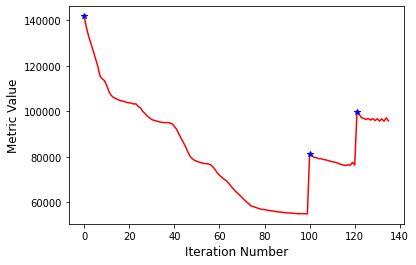

--------
Linear registration:
Final mean squares value: 97420.77134933961
Optimizer stop condition: GradientDescentOptimizerv4Template: Convergence checker passed at iteration 15.
Number of iterations: 15
--------


In [69]:
lin_tranf = est_lin_transf_t(fix_img, mask_4_2, mov_img)

In [73]:
re_mov_img = apply_lin_transf(fix_img, mov_img, lin_tranf)

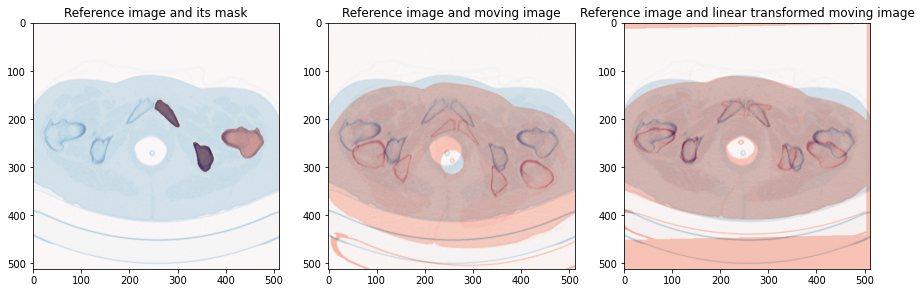

In [75]:
plot_lin_transf(fix_img, mask_4_2, mov_img, re_mov_img, 50)